<a href="https://colab.research.google.com/github/rtindru/CompStats/blob/master/Kensho_Assessment_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 4)
import seaborn as sns
import keras

In [29]:
from google.colab import drive
drive.mount('/content/drive')
PATH = "/content/drive/My Drive/Kensho Asssessment/data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
tdf = pd.read_csv(PATH+'clean_train.csv')

In [31]:
tdf.head()

,Unnamed: 0,abstract,date,subject,title,month,label,clean_abstract,clean_tite,clean_text
0,154543,We contrast analytical results of a variety ...,1992-03-28 00:00:00+00:00,condensed matter,Lack of Self-affinity and Anomalous Roughening...,1992-03-01 00:00:00+00:00,0,We contrast analytical result variety growth m...,Lack Self affinity Anomalous Roughening Growth...,Lack Self affinity Anomalous Roughening Growth...
1,149990,The universal dynamic and static properties ...,1992-04-10 00:00:00+00:00,condensed matter,Universal quantum critical dynamics of two-dim...,1992-04-01 00:00:00+00:00,0,The universal dynamic static property two dime...,Universal quantum critical dynamic two dimensi...,Universal quantum critical dynamic two dimensi...
2,149991,We show that the Halperin-Haldane SQHE wave ...,1992-04-10 00:00:00+00:00,condensed matter,Spin Singlet Quantum Hall Effect and Nonabelia...,1992-04-01 00:00:00+00:00,0,We show Halperin Haldane SQHE wave function wr...,Spin Singlet Quantum Hall Effect Nonabelian La...,Spin Singlet Quantum Hall Effect Nonabelian La...
3,149992,A new class of singlet superconductors with ...,1992-04-10 00:00:00+00:00,condensed matter,A novel class of singlet superconductors,1992-04-01 00:00:00+00:00,0,A new class singlet superconductors gap functi...,A novel class singlet superconductors,A novel class singlet superconductors - A new ...
4,149993,We find the rules which count the energy lev...,1992-04-13 00:00:00+00:00,condensed matter,Physics beyond quasi-particles: Spectrum and c...,1992-04-01 00:00:00+00:00,0,We find rule count energy level 3 state superi...,Physics beyond quasi particle Spectrum complet...,Physics beyond quasi particle Spectrum complet...


In [52]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


MAX_NB_WORDS = 1000
MAX_SEQUENCE_LENGTH = 50
BATCH_SIZE = 200
EPOCHS = 3

# Data has temporality, sort so that we train on past data and predict on recent data 
tdf = tdf.sort_values('date')

# Tokenize the word meanings
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(tdf.clean_tite)
sequences = tokenizer.texts_to_sequences(tdf.clean_tite)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X = pd.DataFrame(pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH))

# Label encode the word labels
le = LabelEncoder()
y = pd.DataFrame(le.fit_transform(tdf.subject))
NUM_CLASSES = len(le.classes_)

# Split data into train, test, and valid
train_size = int(tdf.shape[0] * 0.75)
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

print('Classes: ', NUM_CLASSES)
print('Shape of data tensor:', X_train.shape)
print('Shape of label tensor:', y_train.shape)
print('Shape of data tensor:', X_test.shape)
print('Shape of label tensor:', y_test.shape)

Found 31686 unique tokens.
Classes:  30
Shape of data tensor: (132345, 50)
Shape of label tensor: (132345, 1)
Shape of data tensor: (44115, 50)
Shape of label tensor: (44115, 1)


In [39]:
# # Preload the embedding matrix
# EMBEDDING_DIM = 300  # same as the lenght of the keyed vector
# import gensim

# def get_coefficients(word, model):
#   """
#   Helper method to return coeffs for a model; or zeros!
#   """
#   try:
#     return model.get_vector(word)
#   except KeyError:
#     return np.zeros(model.wv.vector_size)

# gn_model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/petrichor_new/GoogleNews-vectors-negative300.bin.gz', binary=True)

# embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
# for word, i in word_index.items():
#     embedding_matrix[i] = get_coefficients(word, gn_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':


In [53]:
EMBEDDING_DIM = 30  # same as the lenght of the keyed vector

In [54]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D, Bidirectional
from keras.layers import LSTM

NUM_SAMPLES = len(X_train)
LSTM_DIM = 64  # Good to go with 32/64; can be stacked
MAX_LEN = MAX_SEQUENCE_LENGTH
NUM_CLASSES = len(le.classes_)

model = Sequential()
model.add(Embedding(input_dim=len(word_index)+1, output_dim=EMBEDDING_DIM, input_length=MAX_LEN))
model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2, input_length=MAX_SEQUENCE_LENGTH))  # input_shape=(1, 3000, )
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 30)            950610    
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                24320     
_________________________________________________________________
dense_11 (Dense)             (None, 30)                1950      
Total params: 976,880
Trainable params: 976,880
Non-trainable params: 0
_________________________________________________________________
None


In [55]:
_y_train = keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
_y_test = keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
history = model.fit(X_train, _y_train, validation_data=(X_test, _y_test), verbose=True, epochs=EPOCHS)

Epoch 1/3
4136/4136 [==============================] - 355s 84ms/step - loss: 2.0269 - accuracy: 0.3803 - top_k_categorical_accuracy: 0.7820 - val_loss: 1.7193 - val_accuracy: 0.5068 - val_top_k_categorical_accuracy: 0.8264
Epoch 2/3
4136/4136 [==============================] - 349s 84ms/step - loss: 1.5521 - accuracy: 0.5221 - top_k_categorical_accuracy: 0.8858 - val_loss: 1.6519 - val_accuracy: 0.5159 - val_top_k_categorical_accuracy: 0.8441
Epoch 3/3
4136/4136 [==============================] - 348s 84ms/step - loss: 1.5106 - accuracy: 0.5275 - top_k_categorical_accuracy: 0.8942 - val_loss: 1.6533 - val_accuracy: 0.5161 - val_top_k_categorical_accuracy: 0.8479


dict_keys(['loss', 'accuracy', 'top_k_categorical_accuracy', 'val_loss', 'val_accuracy', 'val_top_k_categorical_accuracy'])


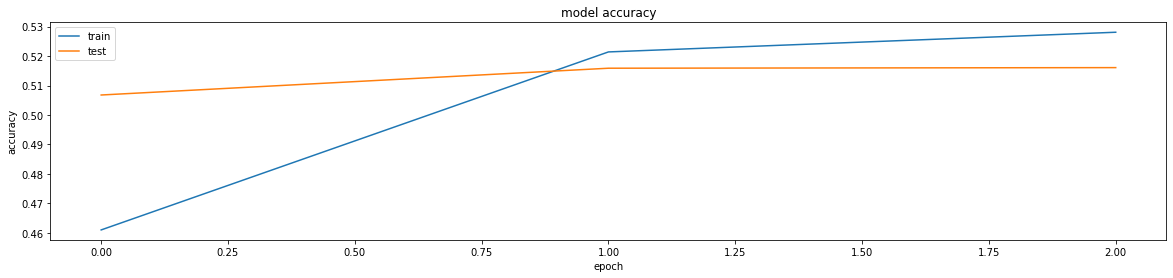

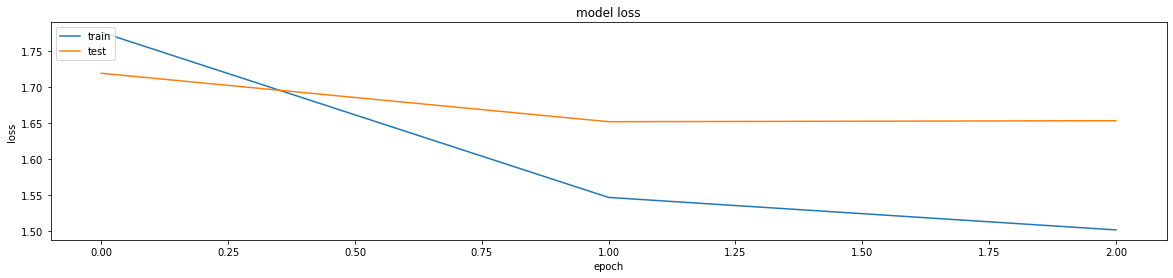

In [56]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Predict on test data


In [ ]:
history = model.fit(X_train, _y_train, validation_data=(X_test, _y_test), verbose=True, epochs=EPOCHS)

In [58]:
vdf = pd.read_csv(PATH+'clean_val.csv')
sequences = tokenizer.texts_to_sequences(vdf.clean_tite)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X_val = pd.DataFrame(pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH))

Found 31686 unique tokens.


In [61]:
y_pred = model.predict(X_val, )

In [77]:
vdf['subject'] = le.inverse_transform(np.argmax(y_pred, axis=1))
vdf['month'] = vdf['date'].astype('datetime64').apply(lambda x: x.replace(day=1))

In [78]:
vdf.dtypes

Unnamed: 0                 int64
abstract                  object
date                      object
subject                   object
title                     object
clean_abstract            object
clean_tite                object
clean_text                object
month             datetime64[ns]
dtype: object

In [79]:
vdf.head()

,Unnamed: 0,abstract,date,subject,title,clean_abstract,clean_tite,clean_text,month
0,0,We predict by first-principles calculations ...,2014-05-01 00:00:00+00:00,superconductivity,Electron-doped phosphorene: A potential monola...,We predict first principle calculation electro...,Electron dope phosphorene A potential monolaye...,Electron dope phosphorene A potential monolaye...,2014-05-01
1,1,Random walk on $\mathbb{N}$ with negative dr...,2014-05-01 00:00:00+00:00,statistical mechanics,Fleming-Viot particle system driven by a rando...,Random walk mathbb N negative drift absorption...,Fleming Viot particle system drive random walk...,Fleming Viot particle system drive random walk...,2014-05-01
2,2,The 0.5(BiGdxFe1-xO3)-0.5(PbZrO3) composite ...,2014-05-01 00:00:00+00:00,materials science,Effect of Electrical Properties on Gd modified...,The 0 5 BiGdxFe1 xO3 0 5 PbZrO3 composite synt...,Effect Electrical Properties Gd modify BiFeO3 ...,Effect Electrical Properties Gd modify BiFeO3 ...,2014-05-01
3,3,"The constitutive modelling of granular, poro...",2014-05-01 00:00:00+00:00,soft condensed matter,Implicit yield function formulation for granul...,The constitutive modelling granular porous qua...,Implicit yield function formulation granular r...,Implicit yield function formulation granular r...,2014-05-01
4,4,Two-dimensional semiconductors such as MoS2 ...,2014-05-01 00:00:00+00:00,materials science,Large-area Epitaxial Monolayer MoS2,Two dimensional semiconductor MoS2 emerge mate...,Large area Epitaxial Monolayer MoS2,Large area Epitaxial Monolayer MoS2 - Two dime...,2014-05-01


In [83]:
sub = vdf[['month', 'subject']].value_counts().reset_index(name="article_count")

In [82]:
sub = pd.read_csv(PATH+'submission.csv')
sub.head()

,date,subject,article_count
0,2014-05-01,condensed matter,0
1,2014-05-01,disordered systems and neural networks,0
2,2014-05-01,general relativity and quantum cosmology,0
3,2014-05-01,high energy physics - lattice,0
4,2014-05-01,high energy physics - phenomenology,0


In [88]:
sub.sort_values('month').to_csv(PATH+'submsson0.csv')

In [93]:
y_train_pred = model.predict(pd.concat([X_train, X_test]))
tdf['pred_sub'] = le.inverse_transform(np.argmax(y_train_pred, axis=1))

In [109]:
def mse(df1, df2):
    return np.sum(np.square(df1['count'] - df2['count']))/df1.shape[0]

df_true = tdf[['month', 'subject']].value_counts().reset_index(name='count').set_index(['month', 'subject']).sort_values(['month', 'subject'])
df_pred = tdf[['month', 'pred_sub']].value_counts().reset_index(name='count').set_index(['month', 'pred_sub']).sort_values(['month', 'pred_sub'])

print(df_true.head())
print(df_pred.head())
print(mse(df_true, df_pred))

                                                         count
month                     subject                             
1992-03-01 00:00:00+00:00 condensed matter                   1
1992-04-01 00:00:00+00:00 condensed matter                  18
1992-05-01 00:00:00+00:00 condensed matter                  16
                          high energy physics - lattice      3
                          high energy physics - theory       2
                                                                  count
month                     pred_sub                                     
1992-03-01 00:00:00+00:00 statistical mechanics                       1
1992-04-01 00:00:00+00:00 condensed matter                            1
                          disordered systems and neural networks      1
                          materials science                           1
                          mesoscale and nanoscale physics             1
91764.10219399538


In [103]:
from sklearn.metrics import classification_report
print(classification_report(tdf.pred_sub, tdf.subject))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                             precision    recall  f1-score   support

                                           condensed matter       0.04      0.19      0.07      2424
                     disordered systems and neural networks       0.42      0.44      0.43      6907
                   general relativity and quantum cosmology       0.00      0.00      0.00         0
                              high energy physics - lattice       0.00      0.50      0.01         6
                        high energy physics - phenomenology       0.02      0.45      0.03        22
                               high energy physics - theory       0.32      0.43      0.37      2140
                                          materials science       0.62      0.53      0.57     26699
                                       mathematical physics       0.00      0.00      0.00         0
                                  mathematics - probability       0.00      0.00      0.00